# Load and check data

In [14]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

from imageio import imread
from wordcloud import WordCloud, STOPWORDS

import gensim
import nltk

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics, model_selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.pipeline import make_pipeline
from sklearn.base import ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV

from keras.models import Sequential, model_from_json
from keras.layers import SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

import xgboost as xgb

| entity | semantic |
|-|-|
| `data_` | dataframes containing both raw data and targets |
| `i_` | indices in `data_` objects |
| `y_` | targets |
| `f_` | features |
| `p_` | predictions of models (incl. cross-validated) |
| `q_` | quality metrics (log loss) |
| `t_` | transformers |

In [2]:
# Load in the train and test datasets
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

data_full = pd.concat([data_train, data_test], ignore_index=True)

print(data_train.shape, data_test.shape, data_full.shape)

data_full.head()

(19579, 3) (8392, 2) (27971, 3)


,author,id,text
0,EAP,id26305,"This process, however, afforded me no means of..."
1,HPL,id17569,It never once occurred to me that the fumbling...
2,EAP,id11008,"In his left hand was a gold snuff box, from wh..."
3,MWS,id27763,How lovely is spring As we looked from Windsor...
4,HPL,id12958,"Finding nothing else, not even gold, the Super..."


In [3]:
# Prepare the id and label for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}

#y_full = data_full.author
y_full = data_full.author.map(author_mapping_dict)

i_train = ~y_full.isnull()
i_test = y_full.isnull()

y_train = data_train.author.map(author_mapping_dict)
#y_train = y_full[i_train]

In [5]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(data_train.shape[0]))
print("Number of rows in test dataset {}".format(data_test.shape[0]))
print("No duplicates in train data") if data_train.shape[0] == data_train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if data_test.shape[0] == data_test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(data_train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(data_train.isnull().sum().sum(), data_test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


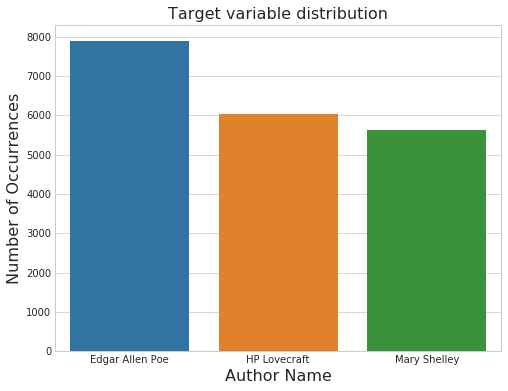

In [6]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=data_train.author.map(z).unique(), y=data_train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

(-0.5, 399.5, 199.5, -0.5)

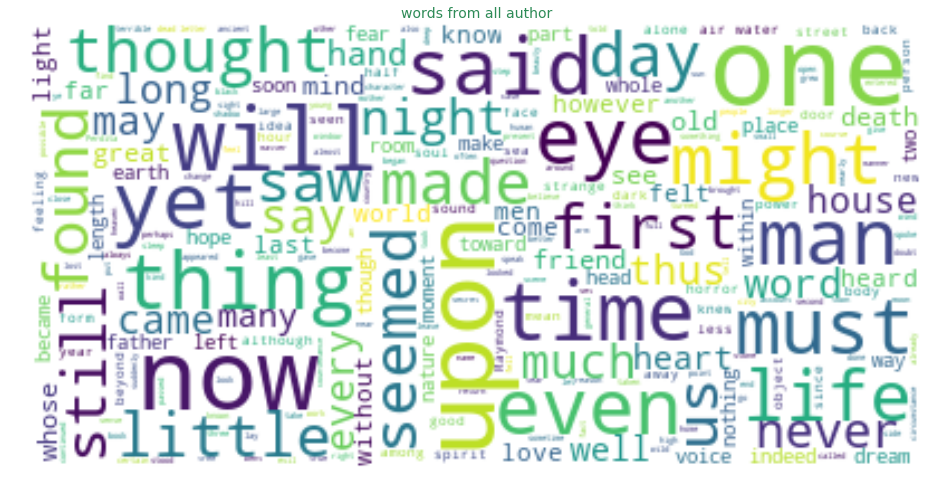

In [7]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(data_train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [8]:
img1 = imread("../images/eap.png")
img2 = imread("../images/mws.png")
img3 = imread("../images/hpl.png")

In [9]:
eap = data_train[data_train.author == "EAP"]["text"].values
mws = data_train[data_train.author == "MWS"]["text"].values
hpl = data_train[data_train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

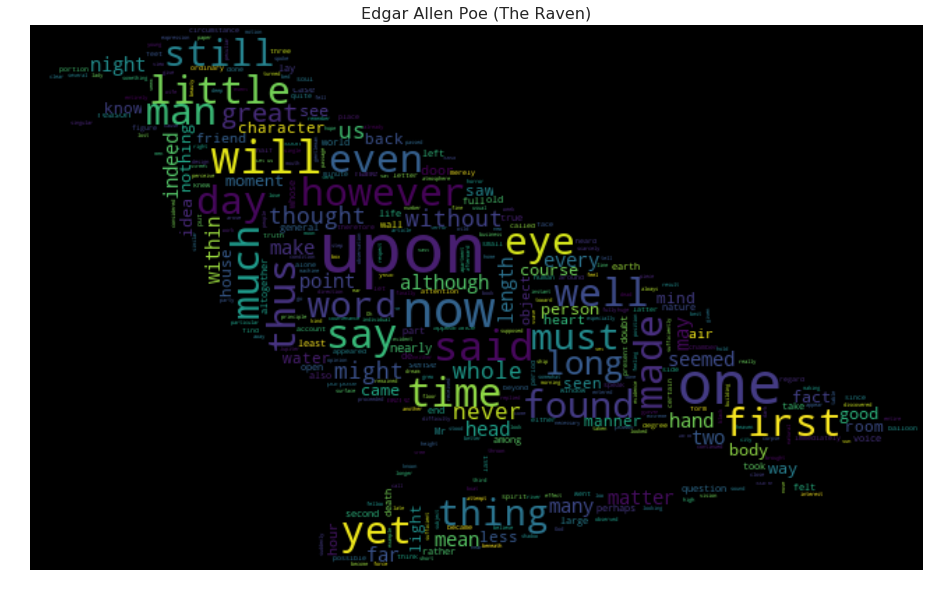

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

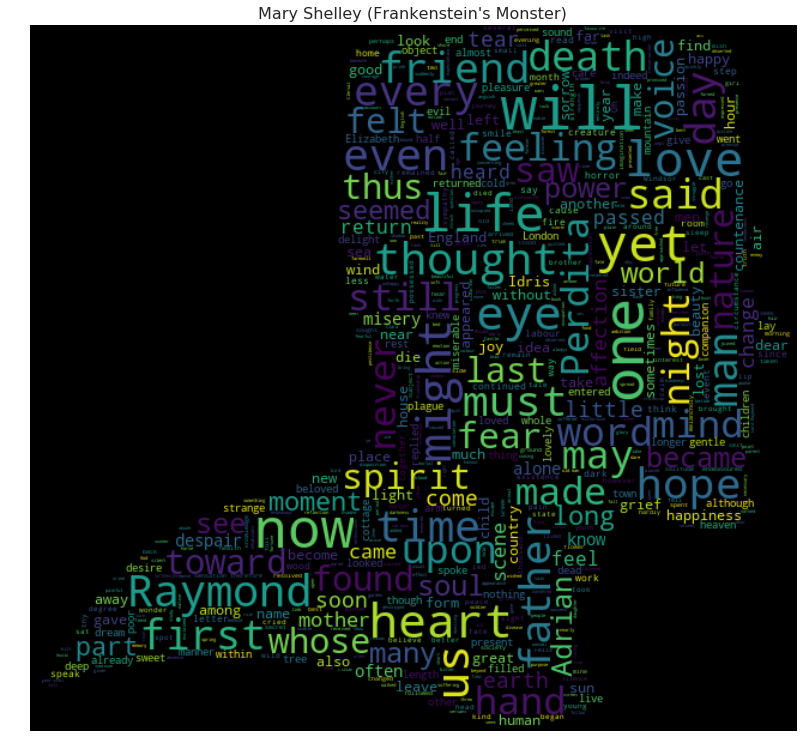

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

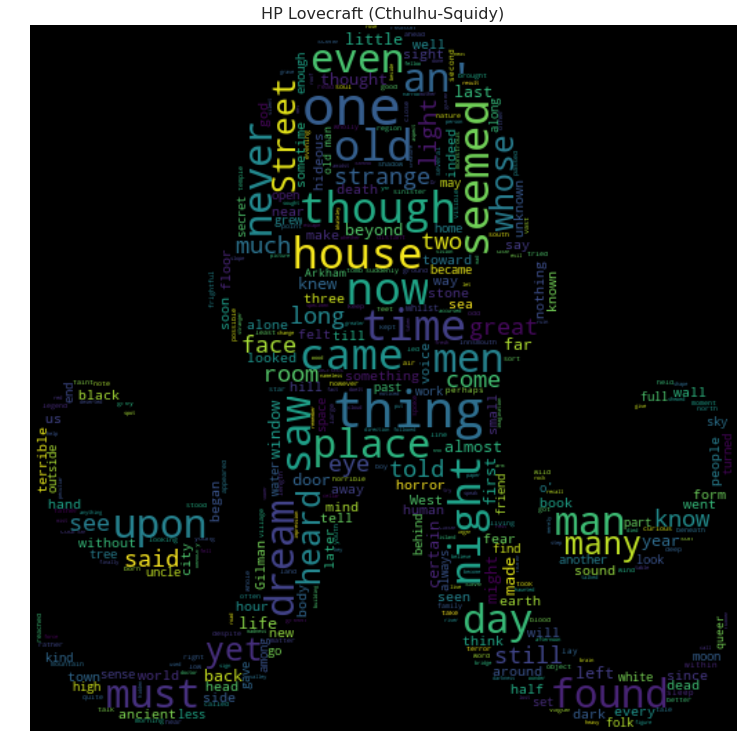

In [12]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [13]:
# Storing the first text element as a string
first_text = data_train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [14]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [16]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [17]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [18]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [19]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [20]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## Basic features

In [21]:
import re
import string


def num_words(raw):
    return len(re.findall(r'\w+', raw['text']))


def num_chars(raw):
    return len(raw['text'])


def mean_len_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def num_unique_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def num_stopwords(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def num_punctuations(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def num_upper_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def num_title_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])

def num_noun_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    return noun_count


def num_adj_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    return adj_count


def num_verbs_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    return verbs_count

In [22]:
def fra_unique_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def fra_stopwords(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def fra_punctuations(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count


def fra_upper_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_upper_count = len([w for w in text_list if w.isupper()])
    word_count = len(text_list)
    return word_upper_count / word_count


def fra_title_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_title_count = len([w for w in text_list if w.istitle()])
    word_count = len(text_list)
    return word_title_count / word_count


def fra_noun_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    word_count = len(text_list)
    return noun_count / word_count


def fra_adj_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    word_count = len(text_list)
    return adj_count / word_count


def fra_verbs_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    word_count = len(text_list)
    return verbs_count / word_count

In [23]:
f_num_words        = data_full.apply(lambda raw: num_words(raw), axis=1).as_matrix()[:, None]
f_num_chars        = data_full.apply(lambda raw: num_chars(raw), axis=1).as_matrix()[:, None]
f_mean_len_words   = data_full.apply(lambda raw: mean_len_words(raw), axis=1).as_matrix()[:, None]

f_num_unique_words = data_full.apply(lambda raw: num_unique_words(raw), axis=1).as_matrix()[:, None]
f_num_stopwords    = data_full.apply(lambda raw: num_stopwords(raw), axis=1).as_matrix()[:, None]
f_num_punctuations = data_full.apply(lambda raw: num_punctuations(raw), axis=1).as_matrix()[:, None]
f_num_upper_words  = data_full.apply(lambda raw: num_upper_words(raw), axis=1).as_matrix()[:, None]
f_num_title_words  = data_full.apply(lambda raw: num_title_words(raw), axis=1).as_matrix()[:, None]

f_num_noun_words   = data_full.apply(lambda raw: num_noun_words(raw), axis=1).as_matrix()[:, None]
f_num_adj_words    = data_full.apply(lambda raw: num_adj_words(raw), axis=1).as_matrix()[:, None]
f_num_verbs_words  = data_full.apply(lambda raw: num_verbs_words(raw), axis=1).as_matrix()[:, None]

f_fra_unique_words = data_full.apply(lambda raw: fra_unique_words(raw), axis=1).as_matrix()[:, None]
f_fra_stopwords    = data_full.apply(lambda raw: fra_stopwords(raw), axis=1).as_matrix()[:, None]
f_fra_punctuations = data_full.apply(lambda raw: fra_punctuations(raw), axis=1).as_matrix()[:, None]
f_fra_upper_words  = data_full.apply(lambda raw: fra_upper_words(raw), axis=1).as_matrix()[:, None]
f_fra_title_words  = data_full.apply(lambda raw: fra_title_words(raw), axis=1).as_matrix()[:, None]

f_fra_noun_words   = data_full.apply(lambda raw: fra_noun_words(raw), axis=1).as_matrix()[:, None]
f_fra_adj_words    = data_full.apply(lambda raw: fra_adj_words(raw), axis=1).as_matrix()[:, None]
f_fra_verbs_words  = data_full.apply(lambda raw: fra_verbs_words(raw), axis=1).as_matrix()[:, None]

In [24]:
f_basic = (
    f_num_words, f_num_chars, f_mean_len_words,
    f_num_unique_words, f_num_stopwords, f_num_punctuations, f_num_title_words, f_num_upper_words,
    f_num_noun_words, f_num_adj_words, f_num_verbs_words,
    f_fra_unique_words, f_fra_stopwords, f_fra_punctuations, f_fra_title_words, f_fra_upper_words,
    f_fra_noun_words, f_fra_adj_words, f_fra_verbs_words
)

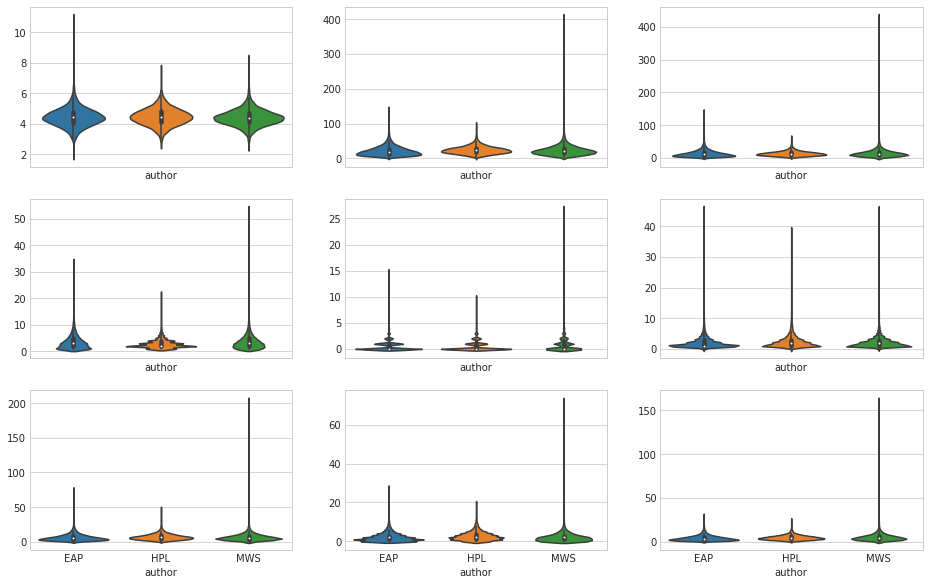

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x=y_full, y=f_mean_len_words.flatten(), ax=ax[0, 0])
sns.violinplot(x=y_full, y=f_num_unique_words.flatten(), ax=ax[0, 1])
sns.violinplot(x=y_full, y=f_num_stopwords.flatten(), ax=ax[0, 2])

sns.violinplot(x=y_full, y=f_num_punctuations.flatten(), ax=ax[1, 0])
sns.violinplot(x=y_full, y=f_num_upper_words.flatten(), ax=ax[1, 1])
sns.violinplot(x=y_full, y=f_num_title_words.flatten(), ax=ax[1, 2])

sns.violinplot(x=y_full, y=f_num_noun_words.flatten(), ax=ax[2, 0])
sns.violinplot(x=y_full, y=f_num_adj_words.flatten(), ax=ax[2, 1])
sns.violinplot(x=y_full, y=f_num_verbs_words.flatten(), ax=ax[2, 2])

## Word features

### Word based 6 features

In [26]:
n_components = 40

# TFIDF features
t_tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 3)) # token_pattern=r'\w{1,}'
f_tfidf = t_tfidf.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf = t_svd_tfidf.fit_transform(f_tfidf)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf = StandardScaler()
f_scl_svd_tfidf = t_scl_svd_tfidf.fit_transform(f_svd_tfidf)

# Counters features
# min_df=3, strip_accents='unicode', token_pattern=r'\w{1,}', sublinear_tf=1,
t_count = CountVectorizer(stop_words="english", ngram_range=(1, 3))
f_count = t_count.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count = t_svd_count.fit_transform(f_count.astype(float)) # float

# Counter with SVD and Scale features
t_scl_svd_count = StandardScaler()
f_scl_svd_count = t_scl_svd_count.fit_transform(f_svd_count)

### Stems based 6 features

In [27]:
stemmer = nltk.stem.PorterStemmer()


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize_s(text):
    tokens = nltk.word_tokenize(text.lower())
    stems = stem_tokens(tokens, stemmer)
    return stems

In [28]:
# TFIDF features
t_tfidf_s = TfidfVectorizer(tokenizer=tokenize_s, stop_words="english", ngram_range=(1, 3))
f_tfidf_s = t_tfidf_s.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_s = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_s = t_svd_tfidf_s.fit_transform(f_tfidf_s)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_s = StandardScaler()
f_scl_svd_tfidf_s = t_scl_svd_tfidf_s.fit_transform(f_svd_tfidf_s)

# Counters features
t_count_s = CountVectorizer(tokenizer=tokenize_s, stop_words="english", ngram_range=(1, 3))
f_count_s = t_count_s.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_s = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_s = t_svd_count_s.fit_transform(f_count_s.astype(float))

# Counters with SVD and Scale features
t_scl_svd_count_s = StandardScaler()
f_scl_svd_count_s = t_scl_svd_count_s.fit_transform(f_svd_count_s)

### Lemmas based 6 features

In [29]:
lemmatizer = nltk.stem.WordNetLemmatizer()


def tokenize_l(text):
    lemms = []
    for i, j in nltk.pos_tag(nltk.word_tokenize(text.lower())):
        if j[0].lower() in ['a', 'n', 'v']:
            lemms.append(lemmatizer.lemmatize(i, j[0].lower()))
        else:
            lemms.append(lemmatizer.lemmatize(i))
    return lemms

In [30]:
# TFIDF features
t_tfidf_l = TfidfVectorizer(tokenizer=tokenize_l, stop_words="english", ngram_range=(1, 3))
f_tfidf_l = t_tfidf_l.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_l = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_l = t_svd_tfidf_l.fit_transform(f_tfidf_l)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_l = StandardScaler()
f_scl_svd_tfidf_l = t_scl_svd_tfidf_l.fit_transform(f_svd_tfidf_l)

# Counters features
t_count_l = CountVectorizer(tokenizer=tokenize_l, stop_words="english", ngram_range=(1, 3))
f_count_l = t_count_l.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_l = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_l = t_svd_count_l.fit_transform(f_count_l.astype(float))

# Counter with SVD and Scale features
t_scl_svd_count_l = StandardScaler()
f_scl_svd_count_l = t_scl_svd_count_l.fit_transform(f_svd_count_l)

## Char 6 featurs

In [31]:
# TFIDF features
t_tfidf_c = TfidfVectorizer(analyzer="char", stop_words="english", ngram_range=(1, 7))
f_tfidf_c = t_tfidf_c.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_c = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_c = t_svd_tfidf_c.fit_transform(f_tfidf_c)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_c = StandardScaler()
f_scl_svd_tfidf_c = t_scl_svd_tfidf_c.fit_transform(f_svd_tfidf_c)

# Counter features
t_count_c = CountVectorizer(analyzer="char", stop_words="english", ngram_range=(1, 7))
f_count_c = t_count_c.fit_transform(data_full.text)

# Counter with SVD features
t_svd_count_c = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_c = t_svd_count_c.fit_transform(f_count_c.astype(float))

# Counter with SVD and Scale features
t_scl_svd_count_c = StandardScaler()
f_scl_svd_count_c = t_scl_svd_count_c.fit_transform(f_svd_count_c)

## Markov event based features

In [32]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

In [33]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model


def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, order, MM):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    for i in range(len(chars)):
        try:
            p_char = MM[list_of_tuples[i]][chars[i]]
            p_chars = sum([x for x in MM[list_of_tuples[i]].values()])
        except:
            p_char = 1
            p_chars = 1
        p += np.log(p_char / p_chars)
    return p


def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [34]:
start_order, end_order = 2, 5 # [start_order, end_order)

data_full['splited_char_list'] = data_full.apply(lambda raw: text_to_char_list(raw), axis=1)

raw_eap = data_full[data_full.author == 'EAP']['splited_char_list'].values
raw_hpl = data_full[data_full.author == 'HPL']['splited_char_list'].values
raw_mws = data_full[data_full.author == 'MWS']['splited_char_list'].values

f_markov_all = []

for order in range(start_order, end_order):
    # build markov model
    eap_MM = make_higher_order_markov_model(raw_eap, order)
    hpl_MM = make_higher_order_markov_model(raw_hpl, order)
    mws_MM = make_higher_order_markov_model(raw_mws, order)

    f_markov_order = []
    # create markov features
    f_markov_order.append(data_full.apply(lambda raw: sent_to_prob(raw, order, eap_MM), axis=1).as_matrix()[:, None])
    f_markov_order.append(data_full.apply(lambda raw: sent_to_prob(raw, order, hpl_MM), axis=1).as_matrix()[:, None])
    f_markov_order.append(data_full.apply(lambda raw: sent_to_prob(raw, order, mws_MM), axis=1).as_matrix()[:, None])
    
    f_markov_all.append(f_markov_order)
    
del data_full['splited_char_list']

In [35]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
#b = normalize(a, axis=1)
#c = StandardScaler().fit_transform(a)

f_markov_all_t = np.array(f_markov_all)

f_markov_orders_t = []

for ii in range(end_order - start_order):
    f_markov_ii = np.hstack(f_markov_all_t[ii])
    f_markov_tt = np.zeros(f_markov_ii.shape)
    for jj, row in enumerate(f_markov_ii):
        f_markov_tt[jj] = (row - row.min()) / (row.max() - row.min())
    f_markov_orders_t.append(f_markov_tt)
f_markov_orders = np.hstack(f_markov_orders_t)

print(f_markov_orders[:10])

[[ 1.          0.          0.16772113  1.          0.60833614  0.          1.
   0.37630461  0.        ]
 [ 0.58846703  1.          0.          0.          1.          0.28418292
   0.07506196  0.          1.        ]
 [ 0.66202864  1.          0.          0.92309812  1.          0.          0.
   1.          0.96239053]
 [ 0.          0.4325704   1.          0.          0.29605612  1.          0.
   0.51933087  1.        ]
 [ 1.          0.10662349  0.          1.          0.22759418  0.
   0.98615862  0.          1.        ]
 [ 0.45431366  0.          1.          0.          0.17466661  1.          0.
   0.70066065  1.        ]
 [ 1.          0.6728816   0.          1.          0.92605932  0.          0.
   0.29794134  1.        ]
 [ 0.          0.59745014  1.          0.06666609  1.          0.          0.
   1.          0.25827497]
 [ 0.          0.09733567  1.          0.          0.55483577  1.          0.
   0.44698411  1.        ]
 [ 0.          0.75269964  1.          0.      

In [36]:
#print(eap_MM[('n', 'o', 'm', 'e')])
#print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
#print(eap_MM[('n', 'o', 'm', 'e')]['r'])
#print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

## Sentence vector features

### word2vec

In [37]:
# Load Google's pre-trained Word2Vec model.
#word2vec = gensim.models.KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin', binary=True)

In [38]:
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')


def sent2vec(sentence):
    text_list = tokenizer.tokenize(sentence.lower())
    text_list = [w for w in text_list if w not in stopwords]
    text_list = [w for w in text_list if w.isalpha()]
    
    M = []
    for w in text_list:
        try:
            M.append(word2vec[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [39]:
#start = time.time()
#
#train_text = train.text.values
#test_text = test.text.values
#sentvec_train = [sent2vec(x) for x in train_text]
#sentvec_test = [sent2vec(x) for x in test_text]
#
#sve_train = np.array(sentvec_train)
#sve_test = np.array(sentvec_test)
#
#print(sve_train.shape, sve_test.shape)
#
#end = time.time()
#print("Time is {}.".format(end - start))

In [17]:
#np.save('../model/sve_train', sve_train)
#np.save('../model/sve_test', sve_test)
sve_train = np.load('../model/sve_train.npy')
sve_test = np.load('../model/sve_test.npy')

f_sentv = np.concatenate((sve_train, sve_test), axis=0)
print(f_sentv.shape)

(27971, 300)


### glove

In [42]:
glove_file = '../glove/glove.840B.300d.txt'


# load the GloVe vectors in a dictionary:
def loadGloveEmbeddings(glove_file):
    embeddings_index = {}
    with open(glove_file) as f:
        for line in tqdm(f):
            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


#loadGloveEmbeddings(glove_file)

## Sentiment Analysis based features

# Neural Networks and Facebook's FastText

## Neural Networks

In [7]:
def nn_model(input_dim, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=32, input_length=max_len))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, 5, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [8]:
max_len = 70
num_words = 10000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data_full.text))
data_full_seq = tokenizer.texts_to_sequences(data_full.text)
data_full_pad = pad_sequences(sequences=data_full_seq, maxlen=max_len)

x_train = data_full_pad[np.nonzero(i_train)]
x_test = data_full_pad[np.nonzero(i_test)]
y_train_enc = np_utils.to_categorical(y_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29451 unique tokens.


In [15]:
input_dim = min(num_words, len(word_index)) + 1

epochs=10
n_splits=5

earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([x_train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train[idx_dev], x_train[idx_val]
    y_dev, y_val = y_train_enc[idx_dev], y_train_enc[idx_val]
    model = nn_model(input_dim, max_len)
    model.fit(
        x_dev,
        y_dev,
        batch_size=32,
        validation_data=(x_val, y_val),
        epochs=epochs,
        callbacks=[earlyStopping])
    pred_y_val = model.predict(x_val)
    pred_y_test = model.predict(x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Train on 9789 samples, validate on 9790 samples
Epoch 1/1
9789/9789 [==============================] - 26s 3ms/step - loss: 0.8985 - acc: 0.5592 - val_loss: 0.5942 - val_acc: 0.7681
Train on 9790 samples, validate on 9789 samples
Epoch 1/1
9790/9790 [==============================] - 24s 2ms/step - loss: 0.8968 - acc: 0.5586 - val_loss: 0.6175 - val_acc: 0.7473
Mean cv score: 0.6058425576845714


In [16]:
p_full = np.concatenate((pred_train, pred_full_test), axis=0)
p_nn = pd.DataFrame(p_full)

## FastTest

In [4]:
# Separate punctuation from words
# Remove lower frequency words ( <= 2)
# Cut a longer document which contains 256 words
def preprocessFastText(text):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    prods = set(text) & signs
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign))
    return text


def create_docs(df, n_gram_max=2):
    def add_ngram(q, n_gram_max):
        ngrams = []
        for n in range(2, n_gram_max + 1):
            for w_index in range(len(q) - n + 1):
                ngrams.append('--'.join(q[w_index:w_index + n]))
        return q + ngrams

    docs = []
    for doc in df.text:
        doc = preprocessFastText(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))

    return docs

In [5]:
min_count = 2
maxlen = 256

docs = create_docs(data_full)
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(docs)

num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs)
docs_seq = tokenizer.texts_to_sequences(docs)
docs_pad = pad_sequences(sequences=docs_seq, maxlen=maxlen)

x_train = docs_pad[np.nonzero(i_train)]
x_test = docs_pad[np.nonzero(i_test)]
y_train_enc = np_utils.to_categorical(y_train)

In [6]:
def fasttext_model(input_dim, embedding_dims, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    return model

In [42]:
input_dim = np.max(docs_pad) + 1
embedding_dims = 20
epochs = 25
n_splits=5

earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([x_train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train[idx_dev], x_train[idx_val]
    y_dev, y_val = y_train_enc[idx_dev], y_train_enc[idx_val]
    model = fasttext_model(input_dim, embedding_dims)
    model.fit(
        x_dev,
        y_dev,
        batch_size=32,
        validation_data=(x_val, y_val),
        epochs=epochs,
        callbacks=[earlyStopping])
    pred_y_val = model.predict(x_val)
    pred_y_test = model.predict(x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Train on 9789 samples, validate on 9790 samples
Epoch 1/1
9789/9789 [==============================] - 13s 1ms/step - loss: 1.0836 - acc: 0.4062 - val_loss: 1.0782 - val_acc: 0.4009
Train on 9790 samples, validate on 9789 samples
Epoch 1/1
9790/9790 [==============================] - 13s 1ms/step - loss: 1.0830 - acc: 0.4010 - val_loss: 1.0730 - val_acc: 0.4065
Mean cv score: 1.0755787798019258


In [44]:
p_full = np.concatenate((pred_train, pred_full_test), axis=0)
p_fasttest = pd.DataFrame(p_full)

(19579, 3) (8392, 3)


# Ensembling & Stacking models

## Helper functions

In [22]:
import scipy.sparse

cv = StratifiedKFold(n_splits=5)


def apply_model(model, features, evaluate=True, predict=False):
    if any(map(lambda z: type(z) in [scipy.sparse.csr_matrix, scipy.sparse.csc_matrix, scipy.sparse.coo_matrix], features)):
        hstack = scipy.sparse.hstack
    else:
        hstack = np.hstack

    f_all = hstack(features)
    f_train = f_all[np.nonzero(i_train)]
    f_test = f_all[np.nonzero(i_test)]
    
    p_cv = model_selection.cross_val_predict(model, f_train, y_train, cv=cv, method="predict_proba")
    q_cv = metrics.log_loss(y_train, p_cv)

    model.fit(f_train, y_train)

    p_train = model.predict_proba(f_train)
    q_train = metrics.log_loss(y_train, p_train)

    if evaluate:
        print(f"train log loss = {q_train:.5f}")
        print(f"   cv log loss = {q_cv:.5f}")

    if predict:
        p_test = model.predict_proba(f_test)
        p_full = np.concatenate((p_cv, p_test), axis=0)
        return pd.DataFrame(p_full)

In [44]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## First level Predictions

In [45]:
from sklearn.calibration import CalibratedClassifierCV

In [46]:
apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="sigmoid"), f_basic)
apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="isotonic"), f_basic)

train log loss = 0.98565
   cv log loss = 0.98649
train log loss = 0.98019
   cv log loss = 0.98873


In [47]:
lr_param_grid = {'C': [0.1, 0.3, 1.0, 3.0, 10.0], 'penalty': ['l1', 'l2']}

nb_param_grid = {'alpha': [0.01, 0.03, 0.1, 0.3, 1, 10, 100]}

rf_param_grid = {
    'n_estimators': [120, 300, 500, 800],
    'max_features': ['log2', 'sqrt', None],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [0.1, 0.3, 1.0, 2, 5],
    'min_samples_leaf': [1, 2, 5, 10, 20]
}

In [48]:
def get_best_parameters(clf, param_grid, features, y_train):
    if any(map(lambda z: type(z) in [scipy.sparse.csr_matrix, scipy.sparse.csc_matrix, scipy.sparse.coo_matrix], features)):
        hstack = scipy.sparse.hstack
    else:
        hstack = np.hstack
        
    f_all = hstack(features)
    f_train = f_all[np.nonzero(i_train)]
    
    model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_log_loss', cv=cv, verbose=0, n_jobs=-1)
        
    model.fit(f_train, y_train)
    best_parameters = model.best_estimator_.get_params()
    
    return best_parameters

### models using Basic features

In [49]:
# lr model
#lr_params = get_best_parameters(LogisticRegression(), lr_param_grid, f_basic, y_train)
#for key, value in lr_params.items():
#    print(key, value)
p_lr_basic = apply_model(LogisticRegression(), f_basic, predict=True)

# nb model
p_nb_basic = apply_model(MultinomialNB(), f_basic, predict=True)

# rf model
p_rf_basic = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), f_basic, predict=True)

# et model
p_et_basic = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), f_basic, predict=True)

train log loss = 0.97770
   cv log loss = 0.98004
train log loss = 1.02633
   cv log loss = 1.02791
train log loss = 0.96795
   cv log loss = 0.98910
train log loss = 1.03205
   cv log loss = 1.03690


### model using word based 6 features

In [50]:
# lr model
p_lr_tfidf = apply_model(LogisticRegression(), (f_tfidf, ), predict=True)
p_lr_svd_tfidf = apply_model(LogisticRegression(), (f_svd_tfidf, ), predict=True)
p_lr_scl_svd_tfidf = apply_model(LogisticRegression(), (f_scl_svd_tfidf, ), predict=True)

p_lr_count = apply_model(LogisticRegression(), (f_count, ), predict=True)
p_lr_svd_count = apply_model(LogisticRegression(), (f_svd_count, ), predict=True)
p_lr_scl_svd_count = apply_model(LogisticRegression(), (f_scl_svd_count, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf = apply_model(MultinomialNB(), (f_tfidf, ), predict=True)
#p_nb_svd_tfidf = apply_model(MultinomialNB(), (f_svd_tfidf, ), predict=True)
#p_nb_scl_svd_tfidf = apply_model(MultinomialNB(), (f_scl_svd_tfidf, ), predict=True)

p_nb_count = apply_model(MultinomialNB(), (f_count, ), predict=True)
#p_nb_svd_count = apply_model(MultinomialNB(), (f_svd_count, ), predict=True)
#p_nb_scl_svd_count = apply_model(MultinomialNB(), (f_scl_svd_count, ), predict=True)

print('---------------------------------')

# rf model
p_rf_tfidf = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf, ), predict=True)
p_rf_svd_tfidf = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf, ), predict=True)
p_rf_scl_svd_tfidf = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf, ), predict=True)

p_rf_count = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count, ), predict=True)
p_rf_svd_count = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count, ), predict=True)
p_rf_scl_svd_count = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count, ), predict=True)

print('---------------------------------')

# et model
p_et_tfidf = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf, ), predict=True)
p_et_svd_tfidf = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf, ), predict=True)
p_et_scl_svd_tfidf = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf, ), predict=True)

p_et_count = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count, ), predict=True)
p_et_svd_count = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count, ), predict=True)
p_et_scl_svd_count = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count, ), predict=True)

train log loss = 0.60284
   cv log loss = 0.83517
train log loss = 0.93480
   cv log loss = 0.94753
train log loss = 0.84288
   cv log loss = 0.84847
train log loss = 0.11811
   cv log loss = 0.53677
train log loss = 0.90106
   cv log loss = 0.90567
train log loss = 0.89953
   cv log loss = 0.90413
---------------------------------
train log loss = 0.46620
   cv log loss = 0.84280
train log loss = 0.03011
   cv log loss = 0.45322
---------------------------------
train log loss = 1.07327
   cv log loss = 1.07576
train log loss = 0.86642
   cv log loss = 0.89514
train log loss = 0.86696
   cv log loss = 0.89658
train log loss = 1.07305
   cv log loss = 1.07543
train log loss = 0.91447
   cv log loss = 0.94349
train log loss = 0.91716
   cv log loss = 0.94865
---------------------------------
train log loss = 1.07900
   cv log loss = 1.08065
train log loss = 1.03967
   cv log loss = 1.04027
train log loss = 1.04621
   cv log loss = 1.04043
train log loss = 1.07510
   cv log loss = 1.0777

### model using word stems based 6 features

In [51]:
# lr model
p_lr_tfidf_s = apply_model(LogisticRegression(), (f_tfidf_s, ), predict=True)
p_lr_svd_tfidf_s = apply_model(LogisticRegression(), (f_svd_tfidf_s, ), predict=True)
p_lr_scl_svd_tfidf_s = apply_model(LogisticRegression(), (f_scl_svd_tfidf_s, ), predict=True)

p_lr_count_s = apply_model(LogisticRegression(), (f_count_s, ), predict=True)
p_lr_svd_count_s = apply_model(LogisticRegression(), (f_svd_count_s, ), predict=True)
p_lr_scl_svd_count_s = apply_model(LogisticRegression(), (f_scl_svd_count_s, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_s = apply_model(MultinomialNB(), (f_tfidf_s, ), predict=True)
#p_nb_svd_tfidf_s = apply_model(MultinomialNB(), (f_svd_tfidf_s, ), predict=True)
#p_nb_scl_svd_tfidf_s = apply_model(MultinomialNB(), (f_scl_svd_tfidf_s, ), predict=True)

p_nb_count_s = apply_model(MultinomialNB(), (f_count_s, ), predict=True)
#p_nb_svd_count_s = apply_model(MultinomialNB(), (f_svd_count_s, ), predict=True)
#p_nb_scl_svd_count_s = apply_model(MultinomialNB(), (f_scl_svd_count_s, ), predict=True)

print('---------------------------------')

# rf model
p_rf_tfidf_s = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_s, ), predict=True)
p_rf_svd_tfidf_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_s, ), predict=True)
p_rf_scl_svd_tfidf_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_s, ), predict=True)

p_rf_count_s = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_s, ), predict=True)
p_rf_svd_count_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_s, ), predict=True)
p_rf_scl_svd_count_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_s, ), predict=True)

print('---------------------------------')

# et model
p_et_tfidf_s = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_s, ), predict=True)
p_et_svd_tfidf_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_s, ), predict=True)
p_et_scl_svd_tfidf_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_s, ), predict=True)

p_et_count_s = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_s, ), predict=True)
p_et_svd_count_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_s, ), predict=True)
p_et_scl_svd_count_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_s, ), predict=True)

train log loss = 0.56389
   cv log loss = 0.77756
train log loss = 0.86421
   cv log loss = 0.87875
train log loss = 0.78510
   cv log loss = 0.79099
train log loss = 0.08449
   cv log loss = 0.49929
train log loss = 0.85516
   cv log loss = 0.86072
train log loss = 0.85424
   cv log loss = 0.85989
---------------------------------
train log loss = 0.44457
   cv log loss = 0.80402
train log loss = 0.02554
   cv log loss = 0.64781
---------------------------------
train log loss = 1.06915
   cv log loss = 1.07156
train log loss = 0.86193
   cv log loss = 0.89243
train log loss = 0.86254
   cv log loss = 0.88931
train log loss = 1.07044
   cv log loss = 1.07182
train log loss = 0.89727
   cv log loss = 0.92662
train log loss = 0.89768
   cv log loss = 0.92332
---------------------------------
train log loss = 1.07621
   cv log loss = 1.07876
train log loss = 0.99453
   cv log loss = 1.01554
train log loss = 1.00420
   cv log loss = 1.01388
train log loss = 1.07396
   cv log loss = 1.0758

### model using word lemmas based 6 features

In [52]:
# lr model
p_lr_tfidf_l = apply_model(LogisticRegression(), (f_tfidf_l, ), predict=True)
p_lr_svd_tfidf_l = apply_model(LogisticRegression(), (f_svd_tfidf_l, ), predict=True)
p_lr_scl_svd_tfidf_l = apply_model(LogisticRegression(), (f_scl_svd_tfidf_l, ), predict=True)

p_lr_count_l = apply_model(LogisticRegression(), (f_count_l, ), predict=True)
p_lr_svd_count_l = apply_model(LogisticRegression(), (f_svd_count_l, ), predict=True)
p_lr_scl_svd_count_l = apply_model(LogisticRegression(), (f_scl_svd_count_l, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_l = apply_model(MultinomialNB(), (f_tfidf_l, ), predict=True)
#p_nb_svd_tfidf_l = apply_model(MultinomialNB(), (f_svd_tfidf_l, ), predict=True)
#p_nb_scl_svd_tfidf_l = apply_model(MultinomialNB(), (f_scl_svd_tfidf_l, ), predict=True)

p_nb_count_l = apply_model(MultinomialNB(), (f_count_l, ), predict=True)
#p_nb_svd_count_l = apply_model(MultinomialNB(), (f_svd_count_l, ), predict=True)
#p_nb_scl_svd_count_l = apply_model(MultinomialNB(), (f_scl_svd_count_l, ), predict=True)

print('---------------------------------')

# rf model
p_rf_tfidf_l = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_l, ), predict=True)
p_rf_svd_tfidf_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_l, ), predict=True)
p_rf_scl_svd_tfidf_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_l, ), predict=True)

p_rf_count_l = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_l, ), predict=True)
p_rf_svd_count_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_l, ), predict=True)
p_rf_scl_svd_count_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_l, ), predict=True)

print('---------------------------------')

# et model
p_et_tfidf_l = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_l, ), predict=True)
p_et_svd_tfidf_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_l, ), predict=True)
p_et_scl_svd_tfidf_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_l, ), predict=True)

p_et_count_l = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_l, ), predict=True)
p_et_svd_count_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_l, ), predict=True)
p_et_scl_svd_count_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_l, ), predict=True)

train log loss = 0.57171
   cv log loss = 0.78810
train log loss = 0.88983
   cv log loss = 0.90223
train log loss = 0.82408
   cv log loss = 0.82962
train log loss = 0.09439
   cv log loss = 0.51219
train log loss = 0.86901
   cv log loss = 0.87458
train log loss = 0.86823
   cv log loss = 0.87407
---------------------------------
train log loss = 0.44638
   cv log loss = 0.80741
train log loss = 0.03101
   cv log loss = 0.62511
---------------------------------
train log loss = 1.07057
   cv log loss = 1.07244
train log loss = 0.83207
   cv log loss = 0.86114
train log loss = 0.83263
   cv log loss = 0.85701
train log loss = 1.07062
   cv log loss = 1.07238
train log loss = 0.88983
   cv log loss = 0.91684
train log loss = 0.88939
   cv log loss = 0.91939
---------------------------------
train log loss = 1.07715
   cv log loss = 1.07875
train log loss = 1.01622
   cv log loss = 1.02943
train log loss = 1.00741
   cv log loss = 1.02351
train log loss = 1.07452
   cv log loss = 1.0765

### model using char based 6 features

In [53]:
# lr model
p_lr_tfidf_c = apply_model(LogisticRegression(), (f_tfidf_c, ), predict=True)
p_lr_svd_tfidf_c = apply_model(LogisticRegression(), (f_svd_tfidf_c, ), predict=True)
p_lr_scl_svd_tfidf_c = apply_model(LogisticRegression(), (f_scl_svd_tfidf_c, ), predict=True)

p_lr_count_c = apply_model(LogisticRegression(), (f_count_c, ), predict=True)
p_lr_svd_count_c = apply_model(LogisticRegression(), (f_svd_count_c, ), predict=True)
p_lr_scl_svd_count_c = apply_model(LogisticRegression(), (f_scl_svd_count_c, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_c = apply_model(MultinomialNB(), (f_tfidf_c, ), predict=True)
#p_nb_svd_tfidf_c = apply_model(MultinomialNB(), (f_svd_tfidf_c, ), predict=True)
#p_nb_scl_svd_tfidf_c = apply_model(MultinomialNB(), (f_scl_svd_tfidf_c, ), predict=True)

p_nb_count_c = apply_model(MultinomialNB(), (f_count_c, ), predict=True)
#p_nb_svd_count_c = apply_model(MultinomialNB(), (f_svd_count_c, ), predict=True)
#p_nb_scl_svd_count_c = apply_model(MultinomialNB(), (f_scl_svd_count_c, ), predict=True)

print('---------------------------------')

# rf model
p_rf_tfidf_c = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_c, ), predict=True)
p_rf_svd_tfidf_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_c, ), predict=True)
p_rf_scl_svd_tfidf_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_c, ), predict=True)

p_rf_count_c = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_c, ), predict=True)
p_rf_svd_count_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_c, ), predict=True)
p_rf_scl_svd_count_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_c, ), predict=True)

print('---------------------------------')

# et model
p_et_tfidf_c = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_c, ), predict=True)
p_et_svd_tfidf_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_c, ), predict=True)
p_et_scl_svd_tfidf_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_c, ), predict=True)

p_et_count_c = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_c, ), predict=True)
p_et_svd_count_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_c, ), predict=True)
p_et_scl_svd_count_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_c, ), predict=True)

train log loss = 0.47451
   cv log loss = 0.62743
train log loss = 0.79551
   cv log loss = 0.80604
train log loss = 0.76399
   cv log loss = 0.76820
train log loss = 0.01087
   cv log loss = 0.51650
train log loss = 0.88535
   cv log loss = 0.88960
train log loss = 0.88536
   cv log loss = 0.88960
---------------------------------
train log loss = 0.65026
   cv log loss = 0.91851
train log loss = 0.96735
   cv log loss = 3.77831
---------------------------------
train log loss = 1.03245
   cv log loss = 1.04055
train log loss = 0.91634
   cv log loss = 0.94624
train log loss = 0.91732
   cv log loss = 0.95049
train log loss = 1.03554
   cv log loss = 1.04169
train log loss = 0.97535
   cv log loss = 0.99863
train log loss = 0.96948
   cv log loss = 1.00078
---------------------------------
train log loss = 1.05528
   cv log loss = 1.05951
train log loss = 1.01325
   cv log loss = 1.02063
train log loss = 1.00479
   cv log loss = 1.01997
train log loss = 1.05211
   cv log loss = 1.0566

### models using Markov event based features

In [54]:
# lr model
p_lr_markov = apply_model(LogisticRegression(), (f_markov_orders, ), predict=True)

# nb model
p_nb_markov = apply_model(MultinomialNB(), (f_markov_orders, ), predict=True)

# rf model
p_rf_markov = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_markov_orders, ), predict=True)

# et model
p_et_markov = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_markov_orders, ), predict=True)

train log loss = 0.77384
   cv log loss = 0.77492
train log loss = 0.82247
   cv log loss = 0.82270
train log loss = 0.72885
   cv log loss = 0.74946
train log loss = 0.74788
   cv log loss = 0.75864


### models using Sentence vector features

In [55]:
# lr model
p_lr_sentv = apply_model(LogisticRegression(), (f_sentv, ), predict=True)

# nb model
#p_nb_sentv = apply_model(MultinomialNB(), (f_sentv, ), predict=True)

# rf model
p_rf_sentv = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_sentv, ), predict=True)

# et model
p_et_sentv = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_sentv, ), predict=True)

train log loss = 0.73804
   cv log loss = 0.76125
train log loss = 0.93349
   cv log loss = 0.97465
train log loss = 0.99869
   cv log loss = 1.01448


## Second-Level Predictions

In [61]:
p_xgb_all = apply_model(
    CalibratedClassifierCV(xgb.XGBClassifier(n_estimators=100), method="isotonic"),
    #xgb.XGBClassifier(
    #    learning_rate=0.1,
    #    n_estimators=100,
    #    max_depth=5,
    #    min_child_weight=1,
    #    subsample=0.8,
    #    colsample_bytree=0.5,
    #    missing=-999,
    #    nthread=-1,
    #    silent=1,
    #    objective='multi:softprob',
    #    seed=2017
    #),
    f_basic + (
        f_svd_tfidf, f_scl_svd_tfidf, f_svd_count, f_scl_svd_count,
        
        f_svd_tfidf_s, f_scl_svd_tfidf_s, f_svd_count_s, f_scl_svd_count_s,
        
        f_svd_tfidf_l, f_scl_svd_tfidf_l, f_svd_count_l, f_scl_svd_count_l,
        
        f_svd_tfidf_c, f_scl_svd_tfidf_c, f_svd_count_c, f_scl_svd_count_c,
        
        f_markov_orders,
        
        f_sentv,
        
        p_lr_basic, p_nb_basic, p_rf_basic, p_et_basic,
        
        p_lr_tfidf, p_lr_svd_tfidf, p_lr_scl_svd_tfidf, p_lr_count, p_lr_svd_count, p_lr_scl_svd_count,
        p_nb_tfidf, p_nb_count,
        p_rf_tfidf, p_rf_svd_tfidf, p_rf_scl_svd_tfidf, p_rf_count, p_rf_svd_count, p_rf_scl_svd_count,
        p_et_tfidf, p_et_svd_tfidf, p_et_scl_svd_tfidf, p_et_count, p_et_svd_count, p_et_scl_svd_count,
    
        p_lr_tfidf_s, p_lr_svd_tfidf_s, p_lr_scl_svd_tfidf_s, p_lr_count_s, p_lr_svd_count_s, p_lr_scl_svd_count_s,
        p_nb_tfidf_s, p_nb_count_s,
        p_rf_tfidf_s, p_rf_svd_tfidf_s, p_rf_scl_svd_tfidf_s, p_rf_count_s, p_rf_svd_count_s, p_rf_scl_svd_count_s,
        p_et_tfidf_s, p_et_svd_tfidf_s, p_et_scl_svd_tfidf_s, p_et_count_s, p_et_svd_count_s, p_et_scl_svd_count_s,

        p_lr_tfidf_l, p_lr_svd_tfidf_l, p_lr_scl_svd_tfidf_l, p_lr_count_l, p_lr_svd_count_l, p_lr_scl_svd_count_l,
        p_nb_tfidf_l, p_nb_count_l,
        p_rf_tfidf_l, p_rf_svd_tfidf_l, p_rf_scl_svd_tfidf_l, p_rf_count_l, p_rf_svd_count_l, p_rf_scl_svd_count_l,
        p_et_tfidf_l, p_et_svd_tfidf_l, p_et_scl_svd_tfidf_l, p_et_count_l, p_et_svd_count_l, p_et_scl_svd_count_l,

        p_lr_tfidf_c, p_lr_svd_tfidf_c, p_lr_scl_svd_tfidf_c, p_lr_count_c, p_lr_svd_count_c, p_lr_scl_svd_count_c,
        p_nb_tfidf_c, p_nb_count_c,
        p_rf_tfidf_c, p_rf_svd_tfidf_c, p_rf_scl_svd_tfidf_c, p_rf_count_c, p_rf_svd_count_c, p_rf_scl_svd_count_c,
        p_et_tfidf_c, p_et_svd_tfidf_c, p_et_scl_svd_tfidf_c, p_et_count_c, p_et_svd_count_c, p_et_scl_svd_count_c,

        p_lr_markov, p_nb_markov, p_rf_markov, p_et_markov,
        p_lr_sentv, p_lr_sentv, p_lr_sentv,
        
        p_fasttest, p_nn
    ),
    predict=True)

train log loss = 0.13767
   cv log loss = 0.27763


### Confusion matrix

In [62]:
cnf_matrix = confusion_matrix(y_train, np.argmax(p_xgb_all[i_train].values, axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

ValueError: Mix of label input types (string and number)

In [64]:
import os.path

def make_submission(predictions, submission_path, file_name):
    file_name = os.path.join(submission_path, os.path.basename(file_name))
    predictions = predictions.copy()
    predictions.columns = ['EAP', 'HPL', 'MWS']
    pd.concat(
        (data_test["id"].reset_index(drop=True),
         predictions[i_test].reset_index(drop=True)),
        axis=1).to_csv(file_name, index=False)

In [65]:
make_submission(p_xgb_all, '../result', "p_xgb_all-20171207-03.csv")

### Checkpoint

In [20]:
#train.to_pickle('../model/train-20171205-04-add-markov.pkl')
#test.to_pickle('../model/test-20171205-04-add-markov.pkl')
train = pd.read_pickle('../model/train-20171205-04-add-markov.pkl')
test = pd.read_pickle('../model/test-20171205-04-add-markov.pkl')

train.head()

,id,text,author,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,...,lr_oof_markov_mws,mnb_oof_markov_eap,mnb_oof_markov_hpl,mnb_oof_markov_mws,rf_oof_markov_eap,rf_oof_markov_hpl,rf_oof_markov_mws,et_oof_markov_eap,et_oof_markov_hpl,et_oof_markov_mws
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,4.487805,35,20,7,2,...,0.071754,0.770783,0.129443,0.099774,0.735629,0.140664,0.123707,0.722126,0.158460,0.119414
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,4.071429,14,8,1,0,...,0.023169,0.265983,0.623600,0.110417,0.253184,0.602714,0.144102,0.308940,0.562522,0.128538
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,4.444444,32,17,5,0,...,0.004432,0.435538,0.500189,0.064274,0.323982,0.541249,0.134769,0.426293,0.459659,0.114048
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,4.970588,31,13,4,0,...,0.639241,0.188070,0.275640,0.536290,0.250293,0.175839,0.573868,0.214350,0.217635,0.568015
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,5.333333,25,11,4,0,...,0.028562,0.768244,0.112554,0.119202,0.734594,0.141773,0.123633,0.739373,0.149923,0.110704


In [60]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# load json and create model
json2_file = open('model2.json', 'r')
loaded_model2_json = json2_file.read()
json2_file.close()
loaded_model2 = model_from_json(loaded_model2_json)
loaded_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model2.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [66]:
#score = loaded_model.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

lstm_train = loaded_model.predict(xtrain_pad, batch_size=256)
lstm_test = loaded_model.predict(xtest_pad, batch_size=256)

lstm_train[:10]

array([[ 0.51632798,  0.25286543,  0.23080659],
       [ 0.16239415,  0.30062905,  0.53697675],
       [ 0.53022891,  0.31512594,  0.15464525],
       [ 0.77481425,  0.1359192 ,  0.08926644],
       [ 0.13735546,  0.80081326,  0.0618312 ],
       [ 0.6158886 ,  0.25798211,  0.12612936],
       [ 0.2304244 ,  0.62313491,  0.14644065],
       [ 0.29038092,  0.4478209 ,  0.26179823],
       [ 0.414083  ,  0.5184567 ,  0.06746029],
       [ 0.52510774,  0.28421497,  0.1906773 ]], dtype=float32)

In [67]:
#score = loaded_model2.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

gru_train = loaded_model2.predict(xtrain_pad, batch_size=256)
gru_test = loaded_model2.predict(xtest_pad, batch_size=256)

gru_train[:10]

array([[ 0.4468604 ,  0.27969381,  0.27344584],
       [ 0.13588952,  0.26042879,  0.60368162],
       [ 0.37065294,  0.43356717,  0.19577986],
       [ 0.64107227,  0.26480281,  0.09412484],
       [ 0.18414539,  0.69578528,  0.1200693 ],
       [ 0.56225026,  0.29033524,  0.14741449],
       [ 0.20580117,  0.65319759,  0.14100125],
       [ 0.25149843,  0.39366356,  0.35483807],
       [ 0.37336779,  0.53096133,  0.0956709 ],
       [ 0.42682225,  0.3303639 ,  0.24281389]], dtype=float32)

In [68]:
np.save('../model/lstm_train', lstm_train)
np.save('../model/gru_train', gru_train)

In [69]:
columns = ['lstm_eap', 'lstm_hpl', 'lstm_mws']
train = pd.concat([train, pd.DataFrame(lstm_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lstm_test, columns=columns)], axis=1)

columns = ['gru_eap', 'gru_hpl', 'gru_mws']
train = pd.concat([train, pd.DataFrame(gru_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(gru_test, columns=columns)], axis=1)

### First-level output as new features

#### kfold method

In [21]:
# Prepare the data for modeling
drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 364) (8392, 364)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,lr_oof_markov_mws,mnb_oof_markov_eap,mnb_oof_markov_hpl,mnb_oof_markov_mws,rf_oof_markov_eap,rf_oof_markov_hpl,rf_oof_markov_mws,et_oof_markov_eap,et_oof_markov_hpl,et_oof_markov_mws
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.071754,0.770783,0.129443,0.099774,0.735629,0.140664,0.123707,0.722126,0.158460,0.119414
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,0.023169,0.265983,0.623600,0.110417,0.253184,0.602714,0.144102,0.308940,0.562522,0.128538
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.004432,0.435538,0.500189,0.064274,0.323982,0.541249,0.134769,0.426293,0.459659,0.114048
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,0.639241,0.188070,0.275640,0.536290,0.250293,0.175839,0.573868,0.214350,0.217635,0.568015
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,0.028562,0.768244,0.112554,0.119202,0.734594,0.141773,0.123633,0.739373,0.149923,0.110704


In [22]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break # important, only run once

#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:0.996124	val-mlogloss:0.995866
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.281235	val-mlogloss:0.289034
[80]	train-mlogloss:0.234831	val-mlogloss:0.261297
[120]	train-mlogloss:0.207297	val-mlogloss:0.255918
[160]	train-mlogloss:0.185845	val-mlogloss:0.254443
[200]	train-mlogloss:0.167378	val-mlogloss:0.254094
[240]	train-mlogloss:0.151557	val-mlogloss:0.254465
Stopping. Best iteration:
[191]	train-mlogloss:0.171491	val-mlogloss:0.253714

Mean cv score: 0.2537138345236064


In [25]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171206-05-add-markov.csv", index=False)

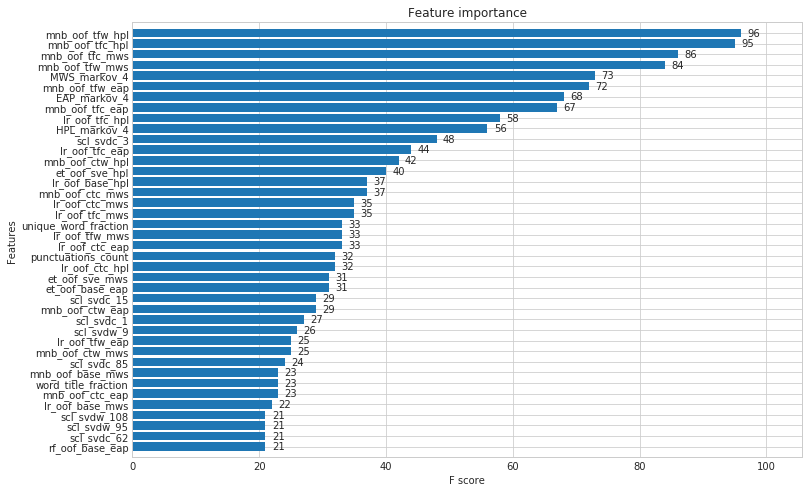

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1387   49  100]
 [  74 1058   36]
 [ 100   47 1065]]


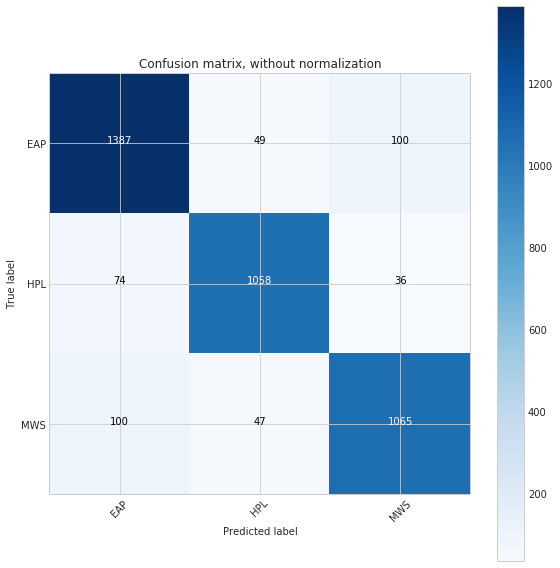

In [71]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

#### train_test_split method

In [23]:
xtrain, xval, ytrain, yval = model_selection.train_test_split(
    x_train, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(x_test)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:0.996133	valid-mlogloss:0.996175
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.281451	valid-mlogloss:0.289008
[80]	train-mlogloss:0.234406	valid-mlogloss:0.261672
[120]	train-mlogloss:0.206549	valid-mlogloss:0.255631
[160]	train-mlogloss:0.18558	valid-mlogloss:0.254232
[200]	train-mlogloss:0.166806	valid-mlogloss:0.255066
Stopping. Best iteration:
[184]	train-mlogloss:0.174003	valid-mlogloss:0.254109



In [24]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171206-04-add-markov.csv", index=False)

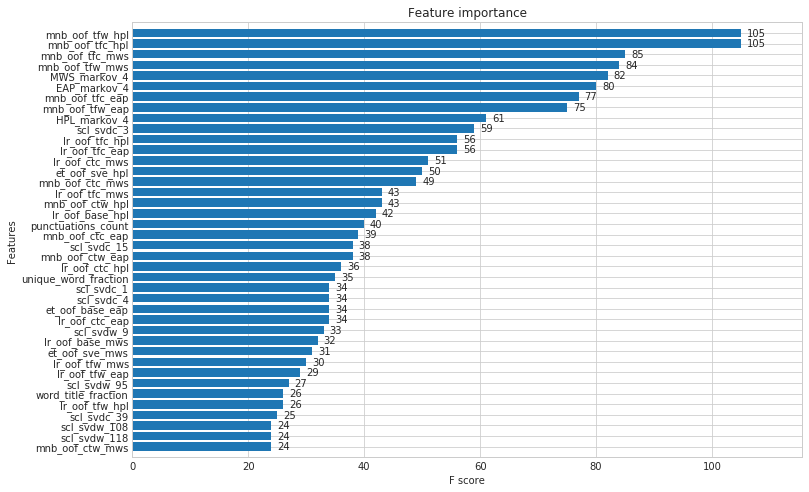

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

#### fine tune xgboost

In [87]:
drop_elements = ['id', 'text', 'mnb_oof_tfc_eap', 'mnb_oof_tfc_hpl', 'mnb_oof_tfc_mws']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

In [88]:
params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

xgb_params = {
    'learning_rate': [0.1],  # [0.01, 0.03, 0.1, 0.3] 0.1
    'n_estimators': [100], # [10, 100, 300, 100] 100
    'max_depth': [5],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.5], # [0.5, 0.7]
    'missing': [-999],
    'nthread': [-1],
    'silent': [1],
    'objective': ['multi:softprob'],
    'seed': [2017]
}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(
    xgb_model,
    xgb_params,
    n_jobs=-1,
    scoring='neg_log_loss',
    verbose=2,
    refit=True)
clf.fit(xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 2.1min

[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total=13.7min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 8.6min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 83.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3], 'n_estimators': [100, 300, 1000], 'max_depth': [5], 'min_child_weight': [1], 'subsample': [0.8], 'colsample_bytree': [0.5, 0.7], 'missing': [-999], 'nthread': [-1], 'silent': [1], 'objective': ['multi:softprob'], 'seed': [2017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

In [89]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: -0.272440835535
colsample_bytree: 0.5
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
missing: -999
n_estimators: 100
nthread: -1
objective: 'multi:softprob'
seed: 2017
silent: 1
subsample: 0.8


/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [96]:
pred_y_test = clf.predict_proba(x_test)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171205-04-finetune-xgb.csv", index=False)

# Feature Engineering

## Naive Bayes model using Text based features

In [79]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Mean cv score: 1.039853560846631


## lda TODO

In [60]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [61]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf_train)


n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape


first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

Topics in LDA model: 

Topic #0: long think appeared subject time die peculiar escape regard public miserable duty law health ye mentioned vague evidently hope moment

Topic #1: eye hand hour moment came left time fear far water face moon general saw turned lay longer large foot away

Topic #2: love beauty secret sun thought shore silent wind act mountain music long cloud covered sea rich reality heart sky native

Topic #3: child sleep street perdita saw home imagination cast lord tomb window threw enemy house early vain ancient melancholy progress raymond

Topic #4: shall eye began raymond adrian expression head hand cottage later terrible lovely yes feel deep changed answer limb grave frame

Topic #5: man day night life like old word great did year dream father said body little time thing come light friend

Topic #6: thing said good let sound certain heard felt know say thought character did world matter present old kind nature earth

Topic #7: wide opinion say burst fly captain view